In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import utils
import importlib

In [3]:
path_to_data = "./cifar10"

In [4]:
# Define transformations (normalization, conversion to tensor)
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Load full CIFAR-10 dataset
lab_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=default_transform)

Files already downloaded and verified


In [1]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img

In [29]:
import imageio

import torchvision.transforms.functional as F

# Load a sample image from the dataset
sample_image, _ = lab_dataset[19]

# Convert the tensor image to a PIL image
sample_image_pil = F.to_pil_image(sample_image)

# List to store images for the GIF
images_for_gif = [sample_image_pil]

transformed_image = ShearX(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = ShearY(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = TranslateX(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = TranslateXabs(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = TranslateY(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = TranslateYabs(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Rotate(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = AutoContrast(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Invert(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Equalize(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Flip(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Solarize(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

# transformed_image = SolarizeAdd(sample_image_pil)
# transformed_image = transforms.Resize(224)(transformed_image)
# images_for_gif.append(transformed_image)

transformed_image = Posterize(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Contrast(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Color(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Brightness(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Sharpness(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = Cutout(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

transformed_image = CutoutAbs(sample_image_pil, 0.2)
transformed_image = transforms.Resize(224)(transformed_image)
images_for_gif.append(transformed_image)

# transformed_image = SamplePairing(sample_image_pil, 0.2)
# transformed_image = transforms.Resize(224)(transformed_image)
# images_for_gif.append(transformed_image)


# Save the images as a GIF
imageio.mimsave('frog.gif', images_for_gif, duration=500, loop=0)

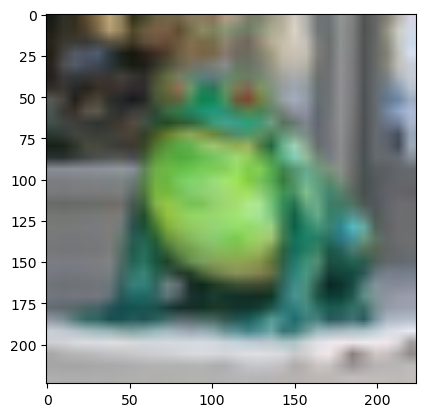

In [26]:
plt.imshow(lab_dataset[19][0].permute(1, 2, 0))

In [21]:
import imageio

import torchvision.transforms.functional as F

# Load a sample image from the dataset
sample_image, _ = lab_dataset[0]

# Convert the tensor image to a PIL image
sample_image_pil = F.to_pil_image(sample_image)

# List to store images for the GIF
images_for_gif = [sample_image_pil]

for transfo in transformations:
    transformed_image = transfo(sample_image)
    # transformed_image = default_transform(transformed_image)
    transformed_image = transforms.Resize(224)(transformed_image)
    transformed_image_pil = F.to_pil_image(transformed_image)
    images_for_gif.append(transformed_image_pil)

# Save the images as a GIF
imageio.mimsave('transformations_RA.gif', images_for_gif, duration=500)

NameError: name 'transformations' is not defined